<a href="https://colab.research.google.com/github/Aquib-Nawaz/Hello/blob/master/Hackathon_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Libraries and load key

In [ ]:
!pip install -U python-dotenv langchain_mistralai google-generativeai langchain langchain-groq faiss-cpu milvus pymilvus unstructured tiktoken lark langchain-community langchain-google-genai langgraph pandas pypdf PyMuPdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of langchain-google-genai to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:

import os
import dotenv

dotenv.load_dotenv( './.env')

False

In [ ]:
import os
import getpass
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")
if "GOOGLE_API_KEY" not in os.environ:
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Gemini API key: ")
if "MISTRAL_API_KEY" not in os.environ:
    os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter your Mistral API key: ")
# os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter your Mistral API key: ")

os.environ["MISTRAL_API_KEY"]

Enter your Groq API key: ··········
Enter your Gemini API key: ··········
Enter your Mistral API key: ··········


'lE2CXz8GNq8KARLU2ONq0rxF0IdvdGOm'

#Trying something

In [ ]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
import requests
from langchain_community.document_loaders import PyPDFLoader

url = "https://www.federalreserve.gov/apps/reportingforms/Download/DownloadAttachment?guid=83c6e71a-86c2-40b6-a9a5-16e15ca7d2d8"


loader = PyPDFLoader(url)

data = loader.load()


# Sort the list based on the URLs and get the text
concatenated_content = "\n\n\n --- \n\n\n".join(
    data[i].page_content for i in range(len(data))
)


In [ ]:

from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
### Anthropic

# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

# LLM
# expt_llm = "claude-3-opus-20240229"
# llm = ChatGroq(
#     model="llama3-70b-8192",
# )

def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]

# Optional: Check for errors in case tool use is flaky
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(tool_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output





def insert_errors(inputs):
    """Insert errors for tool parsing in the messages"""

    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }
def create_code_gen_chain(){

    # Prompt to enforce tool use
    code_gen_prompt_claude = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """<instructions> You are a coding assistant with expertise in python, you are provided with import statement
                and function definition, you will also be provided with error message
                you are supposed to solve the error. For module not found error you are supposed
                to add code which will install relevant module. Remember don't add any main method.</instructions>""",
            ),
            ("placeholder", "{messages}"),
        ]
    )
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    structured_llm_claude = llm.with_structured_output(code, include_raw=True)
    # Chain with output check
    # code_chain_claude_raw = (
    #     code_gen_prompt_claude | structured_llm_claude | check_claude_output
    # )
    code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output
    return code_gen_chain
}
# No re-try

code_gen_chain = create_code_gen_chain()

In [ ]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

In [ ]:
### Parameter

# # Max tries


### Nodes

from langchain_core.runnables import RunnableConfig
def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """
    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState, config: RunnableConfig):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """
    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    max_iterations = 3
    # Reflect
    # flag = 'reflect'
    flag = "do not reflect"
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [ ]:
from langgraph.graph import END, StateGraph, START


def create_code_gen_graph():

    workflow = StateGraph(GraphState)

    # Define the nodes
    workflow.add_node("generate", generate)  # generation solution
    workflow.add_node("check_code", code_check)  # check code
    workflow.add_node("reflect", reflect)  # reflect

    # Build graph
    workflow.add_edge(START, "check_code")
    workflow.add_edge("generate", "check_code")
    workflow.add_conditional_edges(
        "check_code",
        decide_to_finish,
        {
            "end": END,
            "reflect": "reflect",
            "generate": "generate",
        },
    )
    workflow.add_edge("reflect", "generate")
    return workflow.compile()

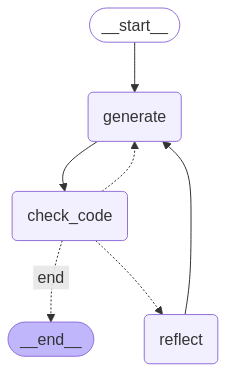

In [ ]:
from IPython.display import Image, display

app = create_code_gen_graph()

config = {"configurable":{"model": model, "concatenated_content":[]}}
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""}, config=config)

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---


#Generated code

In [ ]:
import pandas as pd
from datetime import datetime, date, timedelta
import logging
import iso4217
import os

# Configuration
LOG_FILE = 'transaction_validation.log'
FAILED_TRANSACTIONS_FILE = 'failed_transactions.csv'
HIGH_RISK_COUNTRIES = ['Syria', 'Iran', 'North Korea', 'Sudan']  # Example list - expand as needed
CROSS_BORDER_THRESHOLD = 10000
ACCEPTED_JURISDICTIONS = ['USA', 'Canada', 'UK', 'Germany', 'France'] # Example List

# Set up logging
logging.basicConfig(filename=LOG_FILE, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def is_valid_iso4217_currency(currency_code):
    """
    Checks if a currency code is a valid ISO 4217 currency.
    """
    try:
        iso4217.Currency(currency_code)
        return True
    except ValueError:
        return False


def validate_transaction(df):
    """
    Validates transaction data against regulatory profiling instructions.
    """

    failed_transactions = []

    for index, row in df.iterrows():
        errors = []

        # 1. Transaction Amount vs. Reported_Amount
        transaction_amount = row['Transaction_Amount']
        reported_amount = row['Reported_Amount']
        if transaction_amount != reported_amount:
            # Apply 1% deviation for cross-currency (assuming if currency != USD it's cross-currency for simplicity)
            if row['Currency'] == 'USD':  # Example: consider USD as base currency
                if abs(transaction_amount - reported_amount) > 0.01 * max(transaction_amount, reported_amount):
                    errors.append(
                        "Transaction Amount and Reported Amount do not match (no cross-currency deviation allowed)."
                        f" Transaction Amount: {transaction_amount}, Reported Amount: {reported_amount}. "
                        "Remediation: Investigate the discrepancy and correct the Reported Amount."
                    )
            else:
                deviation = abs(transaction_amount - reported_amount) / max(transaction_amount, reported_amount)
                if deviation > 0.01:
                    errors.append(
                        "Transaction Amount and Reported Amount do not match, exceeding 1% deviation allowed for "
                        "cross-currency transactions."
                        f" Transaction Amount: {transaction_amount}, Reported Amount: {reported_amount}. "
                        "Remediation: Verify exchange rate and correct the Reported Amount if needed."
                    )

        # 2. Account Balance Validation
        account_balance = row['Account_Balance']
        if account_balance < 0 and not isinstance(row['Risk_Source'], str) and 'OD' not in row['Risk_Source']:  #Assuming Risk_Source can contain 'OD' if it's overdraft

            errors.append(
                "Account Balance is negative for a non-overdraft account."
                f" Account Balance: {account_balance}. "
                "Remediation: Review the account type and balance; correct if necessary or flag as Overdraft."
            )

        # 3. Currency Code Validation
        currency = row['Currency']
        if not is_valid_iso4217_currency(currency):
            errors.append(
                f"Invalid Currency Code: {currency}. Remediation: Correct the currency code to a valid ISO 4217 "
                "currency code."
            )

        # 4. Cross-Border Transaction Limits (Simplified - needs real limit data)
        # Assume all transactions to countries other than 'USA' are cross-border.
        country = row['Country']
        if country != 'USA': #Example
           #Placeholder for real limit lookup logic
           pass
           #Implement Regulatory Lookup for country and currency
           #Example:  if row['Transaction_Amount'] > LIMIT: errors.append("Cross-Border Limit Exceeded")

        # 5. Country Jurisdiction Check
        if row['Country'] not in ACCEPTED_JURISDICTIONS:
            errors.append(
                f"Invalid Jurisdiction: {row['Country']}. Remediation: Update the Country field with an accepted "
                "jurisdiction."
            )

        # 6. Cross-Border Transaction Remarks
        if country != 'USA' and transaction_amount > CROSS_BORDER_THRESHOLD and (not isinstance(row['Risk_Source'], str) or len(row['Risk_Source']) == 0):
            errors.append(
                "Missing transaction remarks for a cross-border transaction exceeding "
                f"${CROSS_BORDER_THRESHOLD}. Remediation: Add mandatory transaction remarks."
            )

        # 7. Transaction Date Validation
        transaction_date = pd.to_datetime(row['Transaction_Date'])
        today = date.today()
        age = today - transaction_date.date()

        if transaction_date.date() > today:
            errors.append(
                "Transaction Date is in the future."
                f" Transaction Date: {transaction_date.date()}. Remediation: Correct the Transaction Date."
            )
        elif age > timedelta(days=365):
            logging.warning(f"Old Transaction Date detected: {transaction_date.date()}. Requires further review.")

        # 8. High-Risk Transaction Flagging
        if transaction_amount > 5000 and (country in HIGH_RISK_COUNTRIES):
            logging.warning(
                f"High-Risk Transaction detected: Amount: {transaction_amount}, Country: {country}. Requires an "
                "automatic compliance check."
            )

        # 9. Round-Number Transaction Analysis
        if transaction_amount % 1000 == 0:  # Example: Checking for multiples of 1000
            logging.warning(
                f"Round-Number Transaction detected: Amount: {transaction_amount}. Requires additional validation "
                "steps for potential money laundering risks."
            )
        if errors:
            failed_transactions.append({**row.to_dict(), 'errors': errors})
            logging.error(f"Transaction failed validation: {row['Customer_Id']} - {errors}")


    # Convert failed transactions to DataFrame and save to CSV
    if failed_transactions:
        failed_transactions_df = pd.DataFrame(failed_transactions)

        # Check if file exists, append if it does, create if it doesn't
        if os.path.exists(FAILED_TRANSACTIONS_FILE):
            failed_transactions_df.to_csv(FAILED_TRANSACTIONS_FILE, mode='a', header=False, index=False)
        else:
            failed_transactions_df.to_csv(FAILED_TRANSACTIONS_FILE, header=True, index=False)

    return failed_transactions  # Returning failed transactions for potential further processing

# Example Usage:
if __name__ == '__main__':
    # Create a dummy CSV file for testing
    data = {
        'Customer_Id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'Account_Balance': [1000, -500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
        'Transaction_Amount': [100, 50, 200, 300, 6000, 5000, 1000, 5000, 1000, 5000],
        'Reported_Amount': [100, 50, 200, 300, 6001, 5050, 1000, 5000, 999, 5000],
        'Currency': ['USD', 'USD', 'EUR', 'GBP', 'USD', 'USD', 'USD', 'USD', 'USD', 'USD'],
        'Country': ['USA', 'Canada', 'UK', 'Germany', 'Syria', 'USA', 'USA', 'USA', 'USA', 'USA'],
        'Transaction_Date': ['2023-10-26', '2024-11-15', '2023-01-01', '2025-01-01', '2023-11-15', '2023-11-15',
                             '2023-11-15', '2023-11-15', '2023-11-15', '2023-11-15'],
        'Risk_Source': ['', 'OD', '', '', '', '', '', '', '', ''] #Blank and "OD" examples
    }
    dummy_df = pd.DataFrame(data)
    dummy_df.to_csv('transactions.csv', index=False)

    # Read the CSV file
    try:
        transactions_df = pd.read_csv('transactions.csv')
    except FileNotFoundError:
        print("Error: transactions.csv not found.  Please create it or adjust the file path.")
        exit()

    # Validate the transactions
    failed = validate_transaction(transactions_df)

    if failed:
        print(f"Validation complete. Failed transactions written to {FAILED_TRANSACTIONS_FILE}")
    else:
        print("All transactions passed validation.")

    print(f"Validation log written to {LOG_FILE}")

ERROR:root:Transaction failed validation: 5 - ['Invalid Jurisdiction: Syria. Remediation: Update the Country field with an accepted jurisdiction.']


Validation complete. Failed transactions written to failed_transactions.csv
Validation log written to transaction_validation.log


#ChatGPT HElp

In [ ]:
!curl "https://www.federalreserve.gov/apps/reportingforms/Download/DownloadAttachment?guid=83c6e71a-86c2-40b6-a9a5-16e15ca7d2d8" --output regulatory.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2549k  100 2549k    0     0  3138k      0 --:--:-- --:--:-- --:--:-- 3136k


In [ ]:
import pymupdf
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

from langchain.document_loaders import PyMuPDFLoader
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
import re

# Load PDF
def extract_text_from_pdf(pdf_path):
    doc = pymupdf.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text("text") + "\n"
    return text

# Extract tables (Example using Pandas for structured tables)
def extract_table_rows_from_pdf(pdf_path):
    doc = pymupdf.open(pdf_path)
    table_rows = []
    for page in doc:
        tables = page.find_tables()
        for table in tables:
            df = table.to_pandas()

            # Convert each row into a structured text chunk
            for _, row in df.iterrows():
                row_text = " | ".join(f"{col}: {str(value)}" for col, value in row.items())
                table_rows.append(Document(page_content=(row_text), metadata={"source": "table"}))

            # Create a document for each chunk
    return table_rows

def extract_definitions(text):
    """Find definitions in the document. Adjust regex based on document format."""
    definition_pattern = r"(\b[A-Z][a-zA-Z\s]+\b)[:\-]\s*(.*?)\n"
    matches = re.findall(definition_pattern, text)

    definitions = {term.strip(): definition.strip() for term, definition in matches}
    return definitions


def initializeVectorStore(pdf_path, folder_path):
    try:
        embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
        return FAISS.load_local(folder_path, embedding_model, allow_dangerous_deserialization = True)
    except:
        raw_text = extract_text_from_pdf(pdf_path)
        tables_data = extract_table_rows_from_pdf(pdf_path)

        # Split text into chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
        chunks = text_splitter.split_text(raw_text)
        docs = [Document(page_content=chunk, metadata={"source": "text"}) for chunk in chunks]
        embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
        merged_doc = docs + tables_data
        vectorstore = FAISS.from_documents(merged_doc, embedding_model)
        # Save the vector store
        vectorstore.save_local(folder_path)
        return vectorstore


In [ ]:
import re
def extract_columns(pdf_path):
    doc = pymupdf.open(pdf_path)
    table_rows = []
    data = []
    for page in doc[166:219]:
        tables = page.find_tables()
        for table in tables:
            df = table.to_pandas()

            # Convert each row into a structured text chunk
            table_data = []
            for _, row in df.iterrows():
                strin = re.sub('\\s+','' , row.iloc[1])
                if strin:
                  data.append(strin)
                # row_text = " | ".join(f"{col}: {str(value)}" for col, value in row.items())
                # data.append(row_text)

    for i,x in enumerate(data):
      mg = re.findall(r"\(([^)]*)\)$", x)
      if mg:
          data[i] = re.sub(r"\)",'',mg[-1])
    with open('temp.txt', 'w') as f:
      f.write('\n'.join(data))
extract_columns("regulatory.pdf")

In [ ]:
!rm -rf regulatory_db
vecstore = initializeVectorStore("regulatory.pdf", "regulatory_db")

In [ ]:
import uuid
from langchain_core.runnables import RunnableConfig


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id




In [ ]:
def getVectorStore(dbfolder):
    embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return FAISS.load_local(dbfolder, embedding_model, allow_dangerous_deserialization = True)

In [ ]:
from langchain.prompts import PromptTemplate
from langchain_core.tools import tool
chatbot_main_template_str = """
You are a compliance assistant helping auditor in creating
    profiling rule for bank transaction data based on regulatory reporting instructions.
    Based on question you have to answer providing profiling rules for the columns provided by user:
    You can access chat history by calling search_recall_memories tool similarly you can save important
    context in history by calling save_recall_memory
    You can also access to federal reserve bank regulatory reporting instruction by calling search_document_context tool
    You should not tell user what you are doing.
    Apart from these you will not be provided with anything else any extra context
    you need call search_document_context tool

Question: {question}
Answer:
"""

chatbot_contextualize_query_template_str = """
            You are a helpful assistant that contextualizes the user query depending on the previous conversation
                    queries only if required
            Given a chat history and the latest user question \
            which might reference context in the chat history, formulate a standalone question \
            which can be understood without the chat history. Do NOT answer the question, \
            just reformulate it if and only if needed and otherwise return it as is. \
            History: {history}
            Latest query: {query}

            ANSWER: """
def get_chatbot_maintemplate():
    return PromptTemplate(template=chatbot_main_template_str, input_variables=[ "question"])

def get_chatbot_contextualizequery_template():
    return PromptTemplate(template=chatbot_main_template_str, input_variables=["history", "query"])
@tool
def save_recall_memory(memory: str) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    # user_id = get_user_id(config)
    document = Document(
        page_content=memory,metadata={"source":"history"} ,id=str(uuid.uuid4())#, metadata={"user_id": user_id}
    )
    vecstore.add_documents([document])
    return memory


@tool
def search_recall_memories( query: str) -> List[str]:
    """Search for relevant memories."""
    # user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("source") == "history"

    documents = vecstore.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

@tool
def search_document_context( query: str) -> List[str]:
    """Search for relevant context from documents."""
    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("source") != "history"

    documents = vecstore.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]


In [ ]:

from typing import List, TypedDict
from langchain.docstore.document import Document
from langchain_core.tools import tool, Tool
from langchain_google_genai import ChatGoogleGenerativeAI

# from prompts import get_chatbot_maintemplate, get_chatbot_contextualizequery_template
# from vectorstore import getVectorStore



# Extend the state to include chat_history
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    chat_history: List[str]

class MyChatBot:
    def __init__(self):
        self.chat_history = []
        self.vectorstore = getVectorStore("regulatory_db")
        self.llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
        self.main_prompt = get_chatbot_maintemplate()
        self.history_contextualize_prompt = get_chatbot_contextualizequery_template()
        self.boundagent = self.llm.bind_tools([
            save_recall_memory, search_document_context, search_recall_memories])

    # Application Step 1: Retrieve relevant documents
    def retrieve(self, question) -> dict:
        # Retrieve documents based on similarity search using the question
        self.chat_history += [f"user: {question}"]
        contextualized_query = self.contextualize_query(question)
        retrieved_docs = self.vectorstore.similarity_search(contextualized_query)

        return {"context": retrieved_docs, "question": contextualized_query}

    def contextualize_query(self, query: str):
        """
        Contextualizes the user query based on the conversation history.
        :param query:   The user query
        :param history:    The conversation history
        :return:   The contextualized query
        """
        try:
            message = self.history_contextualize_prompt.invoke({"history": self.chat_history, "query":query})
            response = self.llm.invoke(message)

            return str(response.content)
        except Exception as e:
            print(f"Error contextualizing query: {e}")
            return ""

    # Application Step 2: Generate an answer using the retrieved context and chat history
    def generate(self, query:str):
        # Concatenate the page_content of each document into a single context string
        # state = self.retrieve(query)
        # docs_content = "\n\n".join(doc.page_content for doc in state["context"])

        # Build messages using a prompt template including question, docs_content, and chat_history_text
        messages = self.main_prompt.invoke({
            "question": query,
#            "context": docs_content,
        })


        # Generate a response using the LLM
        response = self.boundagent.invoke(messages)

        # Append the new conversation turn to the chat history
        new_turn = f"assistant: {response.content}"
        self.chat_history += [new_turn]

        return response.content

        # user_id = get_user_id(config

# # Compile application graph: sequence of steps with state propagation
# graph_builder = StateGraph(State).add_sequence([retrieve, generate])
# graph_builder.add_edge(START, "retrieve")
# graph = graph_builder.compile()

#

In [ ]:
chatbot = MyChatBot()
while True:
    # Read user input
    user_question = input("Compliance Officer: ")
    if user_question.lower() in ["exit", "quit"]:
        break
    response = chatbot.generate(user_question)

    # Display the generated answer
    print("\n🔹 Chatbot:", response)

    # Update the chat history with the new conversation turn
    # Each turn is recorded as "Q: <question>\nA: <answer>"

Compliance Officer: Hi there can you tell me what are most important field in loan schedule accordin to document

🔹 Chatbot: 
Compliance Officer: Why are you silent

🔹 Chatbot: I am ready to assist with profiling rules for bank transaction data based on regulatory reporting instructions. How may I help you today?
Compliance Officer: Write on eprofiling rule

🔹 Chatbot: Please provide the column names for which you want me to create profiling rules. I need to know the columns in the bank transaction data to provide relevant and accurate rules.
Compliance Officer: StockExchange

🔹 Chatbot: 
Compliance Officer: Summarize our chat

🔹 Chatbot: 


KeyboardInterrupt: Interrupted by user

#memgpt

In [ ]:

from pydantic import BaseModel, Field
from typing import List, Optional, Union

# Data model
class Code(BaseModel):
    """Schema for validation function."""

    imports: Optional[str] = Field(..., description="import and function")
    body:  Optional[str] = Field(..., description="Function")
    testing:  Optional[str] = Field(..., description="This code is used to test function will "
    "be used just to test if your code is correct")

class ValidationRule(BaseModel):
    """Use this tool to send final message to user"""
    error_message: str = Field(..., description="Brief error message")
    field_name: str = Field(..., description="field name")
    validation_function_name: str = Field(..., description="Function name as defined in prompt")
    arguments: List[Union[str, int]] = Field(
        default_factory=list,
        description="A list of arguments for the validation function",
    )
    # code: Optional[str] = Field(None, description="import statement and function without any main method. This function will be used later by main method")

class ComplianceResponse(BaseModel):
    """Respond to the user with this"""
    extracted_rules: List[ValidationRule] = Field(..., description="List of extracted data validation rules")


In [ ]:
from langchain_core.tools import tool
from typing import Annotated

my_rules = ComplianceResponse(extracted_rules=[])

@tool
def is_integer(field_name: str, description: Annotated[str, "description of the rule"])->str:
    """Regester integer check for field_name"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name,
                                                   description=description, validation_function_name=
        "is_integer"))

    return f"Successfully registered rule for {field_name} with validation function is_integer."

@tool
def is_whole_number(field_name: str, description: str)->str:
    """Register whole number check for field_name"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description = description,
                                                    validation_function_name=
        "is_whole_number"))
    return f"Successfully registered rule for {field_name} with validation function  is_whole_number."

@tool
def is_in_range(field_name: str, description: str, min_v:int, max_v:int)->str:
    """Register whole number check for field_name"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description=description,
                                                    validation_function_name=
        "is_in_range", arguments= [min_v, max_v]))
    return f"Successfully registered rule for {field_name} with validation function  is_in_range."

@tool
def matches_pattern(field_name: str, description: str, pattern: List[str])->str:
    """Register regex pattern check """
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description=description,
                                                    validation_function_name=
        "matches_pattern", arguments= [pattern]))
    return f"Successfully registered rule for {field_name} with validation function matches_pattern."

@tool
def is_in_list(field_name: str, description: str, allowed_values: List[str])->str:
    """Register is in list check"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description=description,
                                                   validation_function_name=
        "is_in_list", arguments= [allowed_values]))
    return f"Successfully registered rule for {field_name} with validation function is_in_list."


@tool
def is_valid_date(field_name: str, description: str, format: str)->str:
    """Register is valid date format check"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description=description, validation_function_name=
        "is_valid_date"))
    return f"Successfully registered rule for {field_name} with validation function is_valid_date. "

registration_rules = [is_integer, is_in_list, is_whole_number, is_valid_date,
                      matches_pattern, is_in_range]

In [ ]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig

from langchain_core.vectorstores import InMemoryVectorStore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain_core.tools import tool, Tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [ ]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    # user_id = get_user_id(config)
    document = Document(
        page_content=memory,metadata={"source":"history"} ,id=str(uuid.uuid4())#, metadata={"user_id": user_id}
    )
    vecstore.add_documents([document])
    return memory


@tool
def search_recall_memories( query: str) -> List[str]:
    """Search for relevant memories."""
    # user_id = get_user_id(config)

    def _filter_function(metadata) -> bool:
        return metadata.get("source") == "history"

    documents = vecstore.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

@tool
def search_document_context( query: str, numberoffields: int) -> List[str]:
    """Search for relevant context from regulatory documents."""
    def _filter_function(metadata) -> bool:
        return metadata.get("source") == "table"

    documents = vecstore.similarity_search(
        query, k=numberoffields+1, filter=_filter_function
    )
    return [document.page_content for document in documents]

class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]
    final_response: ComplianceResponse



In [ ]:
prompt3 = ChatPromptTemplate.from_messages([(
  "system",
  """
You are an expert python developer you have vast experience in profiling data
which are used for regulatory reporting. In this task you will be provided with column names.
Your task is to generate code for all the validation rules pertainin to these columns
1. You are given tool called search_document_context which can be used to extract validation requirement
from regulatory document.
2. You have to give special attention on allowed_values column. In most cases
this column will be enough.
3.Some example of allowed_values column
a.{{Rounded whole dollar amount,
e.g.: 20000000
Supply numeric values without
any non- numeric formatting
(no dollar sign, commas or
decimal).}} this can be interpreted as regex pattern for whole number ,
b. Must be in yyyy- mm-dd format,e.g.: 2005-02-01:- can be interpreted
as date validation.
c. Similarly 2 character country code :- can be interpreted as regex pattern for city code.
d. Enter number code of the description:- check description to find out allowable code value
 usually 1-n function will be integer range checker which takes two additional parameter of min and max
e. one of the given 1.value 2.value1 3.value2 4.value3 so our function will take list of allowed value
as argument and can check if it exists
f. value must be valid code as given in description use in_range min value 1 max value x
highest code in description
4. You have to register each rule by calling corresponding tool description is what will be printed if the
valdation fails example 'field x Should be integer'
5. Remember reporting is most important so your validation rules must include nice description
which can be used to create a informed error message for the cause of failing of rule.
6. For now you can ignore validation rules requiring more than one field
7. You are provided with following predefined validation functions:
a.) def is_integer(value)
    check if field is integer
b.) def is_whole_number(value)
    check if field is whole number
c.) def matches_pattern(value,List[str]):
    provide arguments
    check if any of the regex pattern match
d.) def is_in_range(value, min_val: int, max_val:int)
    check if integer is in range
e.) def is_in_list(value, List[str])
    check if value is in list
f.) def is_valid_date(value)
    check if value is date
Here value is the value of that row and column from csv data file. You are supposed to provide any argument apart from
value if required.

8. Don't make any assumption about the rule
9. You can retrieve context for each column separately for better context
10. You should call registration tool once each for each rule:
  field_name:  field_name ,description : brief rule description
11. You must batch your rule registration tool call so as not to exceed api limit
12. For most of the field you have to call atleast one registration tool
13. Please don't call tool twice for same rule and column
 Recall memories are contextually retrieved based on the current
conversation:\n{recall_memories}\n\n

"Memory Usage Guidelines:\n"
            "1. Actively use memory tools (search_recall_memories, save_recall_memory)"
            " to build a comprehensive understanding of the code.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            4. Don't assume anything

**Output Instruction**
Follow following output format for ComplianceResponse tool rigorously
{schema}

"""),("placeholder", "{messages}")]).partial(schema= ComplianceResponse.model_json_schema())

In [ ]:
code_ge_prompt_with_tools_to_register_rules = ChatPromptTemplate.from_messages([(
  "system",
  """
You are an expert python developer you have vast experience in profiling data
which are used for regulatory reporting. In this task you will be provided with column names.
Your task is to generate code for all the validation rules pertainin to these columns
1. You are given tool called search_document_context which can be used to extract validation requirement
from regulatory document.
2. You have to give special attention on allowed_values column. In most cases
this column will be enough.
3.Some example of allowed_values column
a.{{Rounded whole dollar amount,
e.g.: 20000000
Supply numeric values without
any non- numeric formatting
(no dollar sign, commas or
decimal).}} this can be interpreted as regex pattern for whole number ,
b. Must be in yyyy- mm-dd format,e.g.: 2005-02-01:- can be interpreted
as date validation.
c. Similarly 2 character country code :- can be interpreted as regex pattern for city code.
d. Enter number code of the description:- check description to find out allowable code value
 usually 1-n function will be integer range checker which takes two additional parameter of min and max
e. one of the given 1.value 2.value1 3.value2 4.value3 so our function will take list of allowed value
as argument and can check if it exists
f. value must be valid code as given in description use in_range min value 1 max value x
highest code in description
4. You have to register each rule by calling corresponding tool description is what will be printed if the
valdation fails example 'field x Should be integer'
5. Remember reporting is most important so your validation rules must include nice description
which can be used to create a informed error message for the cause of failing of rule.
6. For now you can ignore validation rules requiring more than one field
7. Please don't register any rule which is not required
8. Don't make any assumption about the rule
9. You can retrieve context for each column separately for better context
10. You should call registration tool once each for each rule:
  field_name:  field_name ,description : brief rule description
11. You must batch your rule registration tool call so as not to exceed api limit
12. For most of the field you have to call atleast one registration tool
13. Please don't call tool twice for same rule and column
 Recall memories are contextually retrieved based on the current
conversation:\n{recall_memories}\n\n

"Memory Usage Guidelines:\n"
            "1. Actively use memory tools (search_recall_memories, save_recall_memory)"
            " to build a comprehensive understanding of the code.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            4. Don't assume anything

"""),("placeholder", "{messages}")])

In [ ]:
recall_memories: List[str]


code_gen_chain_prompt = ChatPromptTemplate.from_messages([(
  "system",
  """
You are an expert python developer you have vast experience in profiling data
which are used for regulatory reporting. In this task you will be provided with column names.
Your task is to generate code for all the validation rules pertainin to these columns
1. You are given tool called search_document_context which can be used to extract validation requirement
from regulatory document.
2. You have to give special attention on allowed_values column. In most cases
this column will be enough.
3.Some example of allowed_values column
a.{{Rounded whole dollar amount,
e.g.: 20000000
Supply numeric values without
any non- numeric formatting
(no dollar sign, commas or
decimal).}} this can be interpreted as regex pattern for whole number ,
b. Must be in yyyy- mm-dd format,e.g.: 2005-02-01:- can be interpreted
as date validation.
c. Similarly 2 character country code :- can be interpreted as regex pattern for city code.
d. Enter number code of the description:- check description to find out allowable code value
 usually 1-n function will be integer range checker which takes two additional parameter of min and max
e. one of the given 1.value 2.value1 3.value2 4.value3 so our function will take list of allowed value
as argument and can check if it exists
4. For many of the fields this allowed_values is same or similar hence
it makes sense to have common function for similar validations i.e for all regex validation
we can call regex_validator function with data and pattern as parameter.
5.You are writing in new file. At first you don't have any function so
you have to generate a function with relevan imports to validate that requirements.
Keep the funciton simple enough so that other similar reuirements can be validated by same function
6.Next time you can just reference the same function by name.
7. Remember reporting is most important so your validation rules must include nice description
which can be used to create a informed error message for the cause of failing of rule.
8. For now you can ignore validation rules recquiring more than one field
 "Recall memories are contextually retrieved based on the current"
9. Please don't write any rule which is not required
10. Write all the rules which are required.
11. You can retrieve context for each column separately for better context
12. function will be called as func(value, *validation_function_argument) so make sure your validation_function_argument
rigorously follows function signature.
13. You can call search_recall_memories to check if such validation function is already
generated hence just name can be provided in this case code will be null.
14. Your code should contain only one function. Code to apply this function will
be written later
15.
" conversation:\n{recall_memories}\n\n"

"Memory Usage Guidelines:\n"
            "1. Actively use memory tools (search_recall_memories, save_recall_memory)"
            " to build a comprehensive understanding of the code.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            4. Don't assume anything

Input data is in csv file which will be loaded in memory as pandas data frame



Output Instuction:
***Important when you are calling tools skip these output instructions call tools***
Output will be list
For each rule you will output in json format :
  rule_id: str = Field(..., description="Unique identifier for the validation rule")
    description: str = Field(..., description="Detailed explanation of the requirement")
    impacted_data_fields: List[str] = Field(..., description="List of affected data fields")
    validation_function_name: str = Field(..., description="Function from chat history you are using to validate this rool or function name from code if code is not null")
    validation_function_argument: Optional[Union[List[int], List[str]] ]  =  Field(..., description="Extra aruments needed for function for.eg"
    "for regex validator it will be regex pattern, for range validator it will be min and max value")
    code: Optional[str] = Field(..., description="import statement and function without any main method. This function will be used later by main method")
eg output:
**No reasoning is required, code should be part of code field not outside of json array, Important Follow the output json structure rigorously. Your output should be json parsable **
{"extracted_rules":[{{"rule_id": "rule1", "description":"impacted_data_fields":["field1", "field2"], "validation_function_name": "func", "validation_function_argument":[1,2],"code":"#some_code" }}]}
"""),("placeholder", "{messages}")])


In [ ]:
# search = TavilySearchResults(max_results=1)
# from langchain_groq import ChatGroq
from langchain_mistralai import ChatMistralAI
from langchain_core.rate_limiters import InMemoryRateLimiter
import time

rate_limiter = InMemoryRateLimiter(
    requests_per_second=.25,  # <-- Super slow! We can only make a request once every 10 seconds!!
    check_every_n_seconds=0.5,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
)
def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]

# model = llm = ChatGroq(
#     model="gemma2-9b-it")

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=os.environ["GOOGLE_API_KEY"], rate_limiter=rate_limiter)
# model = ChatMistralAI(
    # model="mistral-large-latest", api_key = os.environ["MISTRAL_API_KEY"],rate_limiter=rate_limiter)
tools = [save_recall_memory, search_recall_memories, search_document_context]
tools.extend([ComplianceResponse])
# tools.extend(registration_rules)
# model_with_tools = code_gen_chain_prompt | model.bind_tools(tools)#.with_structured_output(ComplianceResponse), include_raw=True) | parse_output
model_with_tools = prompt3 | model.bind_tools(tools, tool_choice="any")#.with_structured_output(ComplianceResponse), include_raw=True) | parse_output


tokenizer = tiktoken.encoding_for_model("gpt-4o")

def respond(state: State):
    # Construct the final answer from the arguments of the last tool call
    weather_tool_call = state["messages"][-1].tool_calls[0]
    try:
      response = ComplianceResponse(**weather_tool_call["args"])
    except Exception as e:
      tool_message = {
        "type": "tool",
        "content": "Parse error {} please fix it".format(str(e)),
        "tool_call_id": weather_tool_call["id"],
      }
      return {"final_response": None, "messages": [tool_message]}

    # Since we're using tool calling to return structured output,
    # we need to add  a tool message corresponding to the WeatherResponse tool call,
    # This is due to LLM providers' requirement that AI messages with tool calls
    # need to be followed by a tool message for each tool call
    tool_message = {
        "type": "tool",
        "content": "Here is your structured response",
        "tool_call_id": weather_tool_call["id"],
    }
    # We return the final answer
    return {"final_response": response, "messages": [tool_message]}

def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )

    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """

    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    # print(f"RecallMemories:- {recall_memories}")
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    # time.sleep(3)
    msg = state["messages"][-1]
    print(msg.tool_calls)
    if (
      len(msg.tool_calls) == 1
      and msg.tool_calls[0]["name"] == "ComplianceResponse"
  ):
        return "respond"
    if msg.tool_calls:
        # print(msg.tool_calls)
        return "tools"

    # elif parse_message(msg)==False:
    #     return "parseerror"
    return "agent"

def route_tools1(state: State):
    if state["final_response"]:
      return END
    return "agent"

# def solve_parse_error(state: State):

#     return {"messages": [("user",
#     "If you want to give final response to user make sure your response should only contain json schema as provided in prompt."
#     "Your response should start with [ begining of list and end with ] end of list."
#     " Each item of thsi list is validation rule in json format"
#     "there should not be any extra text")]}

In [ ]:
def get_graph():
    # Create the graph and add nodes
    builder = StateGraph(State)
    builder.add_node(load_memories)
    builder.add_node(agent)
    builder.add_node("tools", ToolNode(tools))
    builder.add_node("respond", respond)

    # Add edges to the graph
    builder.add_edge(START, "load_memories")
    builder.add_edge("load_memories", "agent")
    builder.add_conditional_edges("agent", route_tools, ["tools", "agent", "respond"])#, "parseerror"])
    builder.add_edge("tools", "agent")
    builder.add_conditional_edges("respond", route_tools1, [END, "agent"])
    # builder.add_edge("parseerror", "agent")
    # Compile the graph
    memory = MemorySaver()
    return builder.compile(checkpointer=memory)

In [ ]:
from pydantic_core import from_json
import unicodedata

def extract_response(text: str) -> ComplianceResponse|None:
    """Extracts JSON content from a string wrapped with ```json...```"""
    try:
        json_str = "{\"extracted_rules\":" + text+ "}"
      # json_str = re.sub(r"\\n", "\n", json_str)
      # json_str = "".join(ch for ch in json_str if unicodedata.category(ch)[0]!="C")
        return ComplianceResponse.model_validate(from_json(json_str))  # Convert string to dict
    except:
        print(f"Failed to parse :- {text}")
        return None

all_rule = ComplianceResponse(extracted_rules=[])

def parse_message(message)->bool:
    response_obj = extract_response(message.content)
    if response_obj is None:
        return False
    all_rule.extracted_rules.extend(response_obj.extracted_rules)
    return True
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

Field for corporate loan schedule InternalObligor
ID, CustomerID, OriginalInternalObligorID, ObligorName, City

In [ ]:
fields =[]
with open('temp.txt', 'r') as f:
    fields = f.readlines()
fields = list(filter(lambda y: y!= 'DONOTUSE', map(lambda x: x.strip(), fields)))

In [ ]:
import time
config = {"configurable": {"user_id": "1", "thread_id": "1"}, "recursion_limit":50}
vectorstore = vecstore
graph = get_graph()
step = 7
my_rules = ComplianceResponse(extracted_rules=[])
for i in range(0, 20, step):
    message = "Field for corporate loan schedule {}".format(', '.join(fields[i:i+step]))
    print(f"{message}")
    state = graph.invoke({"messages": [("user", message)], "recall_memories" :[]
                          }, config=config)
    response = state['messages'][-1]
    time.sleep(2)
    # print(response)
    # for chunk in graph.stream({"messages": [("user", message)]}, config=config):
    #     pretty_print_stream_chunk(chunk)
# message = "Field for corporate loan schedule {}".format(', '.join(fields[0:5]))
# graph.invoke({"messages": [("user", message)], "recall_memories" :[]}, config=config)


Field for corporate loan schedule CustomerID, InternalObligorID, OriginalInternalObligorID, ObligorName, City, Country, ZipCodeForeignMailingCode
[{'name': 'search_document_context', 'args': {'query': 'CustomerID allowed values', 'numberoffields': 1.0}, 'id': 'd0043b72-9424-4099-80e9-76c071f9be4d', 'type': 'tool_call'}]
[{'name': 'search_document_context', 'args': {'query': 'InternalObligorID allowed values', 'numberoffields': 1.0}, 'id': 'ea1b1d3e-c35e-42b4-8f4f-ed4746846eee', 'type': 'tool_call'}]
[{'name': 'search_document_context', 'args': {'query': 'OriginalInternalObligorID allowed values', 'numberoffields': 1.0}, 'id': '4947ea13-ca46-4d24-b82e-d5581d66a1ed', 'type': 'tool_call'}]
[{'name': 'search_document_context', 'args': {'query': 'ObligorName allowed values', 'numberoffields': 1.0}, 'id': '40da0982-3707-4d95-b72b-0369134b8dfa', 'type': 'tool_call'}]
[{'name': 'search_document_context', 'args': {'query': 'City allowed values', 'numberoffields': 1.0}, 'id': 'e8f3d540-23d4-49bf

KeyboardInterrupt: 

In [ ]:
my_rules = ComplianceResponse(extracted_rules=[])
message = "Field for corporate loan schedule Country, City, OriginationDate, MaturityDate, FacilityType"
state = graph.invoke({"messages": [("user", message)], "recall_memories" :[]}, config=config)

In [ ]:
with open('validation', 'w') as f:
  f.write(my_rules.model_dump_json())

In [ ]:
state

In [ ]:
print(list(filter(lambda x:x.code,all_rule.extracted_rules))[0].code)

import re

def regex_validator(data, patterns):
    """
    Validate data against a list of regex patterns.
    """
    for pattern in patterns:
        if re.fullmatch(pattern, data):
            return True
    return False

# Example usage
# data = "123456"  # Example data to validate
# patterns = ["^\d{4,6}$", "^\d{2,4}$", "^[A-Z0-9]{6}$"]  # List of regex patterns
# is_valid = regex_validator(data, patterns)
# print(is_valid)


In [ ]:
_match = re.search(r"```json([\w\W]*)```", response.content, re.DOTALL)
# print(_match)
if _match:
    json_str = "{\"extracted_rules\":" + format(_match.group(1)) + "}"
    json_str = re.sub(r"\\n", "\n", json_str)
    json_str = "".join(ch for ch in json_str if ch=='\n' or unicodedata.category(ch)[0]!="C" )
from_json(json_str)
# from_json('{"testing": """assert date_validator(\"2005-02-01\", \"%Y-%m-%d\") == True"""  }')

In [ ]:
unicodedata.category('\n')[0]

'C'

In [ ]:
'{"testing": """assert date_validator(\"2005-02-01\", \"%Y-%m-%d\") == True"""  }'[14]

'"'

In [ ]:
search_document_context("ParticipationFlag")

[]

In [ ]:
for chunk in graph.stream({"messages": [("user", "Can you print out what context did you get from search_document_context")]}, config=config):
    pretty_print_stream_chunk(chunk)
# graph.invoke({"messages": [("user", "Field for corporate loan schedule column LineReportedOnFRY9C:- allowed_values Enter number code of the description")], "recall_memories" :[]}, config=config)["messages"][-1].content


Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

I apologize, but I cannot directly access or print the context retrieved from the `search_document_context` tool.  That's because I'm designed to only use the available tools and libraries within the given context, and I don't have the capability to display the internal workings or outputs of those tools directly.  I can only use their results to generate code and answer your questions.

When I called `search_document_context`, I didn't receive specific content about the `ParticipationFlag` field that I could display to you.  My response about it having allowed values 'Y' and 'N' was a reasoned assumption based on common data reporting practices and similar field names.  To generate more accurate validation rules, I need the actual content of the relevant regulatory documents or the explicit allowed values for the field.




In [ ]:
import os
import time
import uuid

from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_mistralai import ChatMistralAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import END, START
from langgraph.graph import MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from typing import List, Optional, Union, Annotated



# Data model
class ValidationRule(BaseModel):
    description: str = Field(..., description="Detailed explanation of the requirement")
    field_name: str = Field(..., description="field name")
    validation_function_name: str = Field(...,
                                          description="Function from chat history which can be used for this or generated"
                                                      "function name from code")
    arguments: Optional[Union[List[int], List[str], List[List[str]]]] = Field(...,
                                                                              description="Extra aruments needed for function for.eg"
                                                                                          "for regex validator it will be regex pattern, for range validator it will be min and max value")
    code: Optional[str] = Field(None,
                                description="import statement and function without any main method. This function will be used later by main method")


class ComplianceResponse(BaseModel):
    """Respond to the user with this"""
    extracted_rules: List[ValidationRule] = Field(..., description="List of extracted data validation rules")


@tool
def save_recall_memory(memory: str) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    # user_id = get_user_id(config)
    document = Document(
        page_content=memory, metadata={"source": "history"}, id=str(uuid.uuid4())  # , metadata={"user_id": user_id}
    )
    vecstore.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str) -> List[str]:
    """Search for relevant memories."""

    # user_id = get_user_id(config)

    def _filter_function(metadata) -> bool:
        return metadata.get("source") == "history"

    documents = vecstore.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]


@tool
def search_document_context(query: str) -> List[str]:
    """Search for relevant context from regulatory documents."""

    def _filter_function(metadata) -> bool:
        return metadata.get("source") == "table"

    documents = vecstore.similarity_search(
        query, k=10, filter=_filter_function
    )
    return [document.page_content for document in documents]


class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]


def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = model_with_tools
    recall_str = (
            "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction: ComplianceResponse = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )

    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """

    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    # print(f"RecallMemories:- {recall_memories}")
    return {
        "recall_memories": recall_memories,
    }


from pydantic_core import from_json


def extract_response(text: str) -> ComplianceResponse | None:
    """Extracts JSON content from a string wrapped with ```json...```"""
    try:
        json_str = "{\"extracted_rules\":" + text + "}"
        # json_str = re.sub(r"\\n", "\n", json_str)
        # json_str = "".join(ch for ch in json_str if unicodedata.category(ch)[0]!="C")
        return ComplianceResponse.model_validate(from_json(json_str))  # Convert string to dict
    except:
        print(f"Failed to parse :- {text}")
        return None


def parse_message(message) -> bool:
    response_obj = extract_response(message.content)
    if response_obj is None:
        return False
    # all_rule.extracted_rules.extend(response_obj.extracted_rules)
    return True


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"
    # elif parse_message(msg) == False:
    #     return "parseerror"
    return END


def get_graph():
    # Create the graph and add nodes
    builder = StateGraph(State)
    builder.add_node(load_memories)
    builder.add_node(agent)
    tools = [save_recall_memory, search_recall_memories, search_document_context]
    builder.add_node("tools", ToolNode(tools))
    # builder.add_node("parseerror", solve_parse_error)
    # Add edges to the graph
    builder.add_edge(START, "load_memories")
    builder.add_edge("load_memories", "agent")
    builder.add_conditional_edges("agent", route_tools, ["tools", "agent", END])
    builder.add_edge("tools", "agent")
    # builder.add_edge("parseerror", "agent")
    # Compile the graph
    memory = MemorySaver()
    return builder.compile(checkpointer=memory)


def generate_rules(fields: List[str]):
    global my_rules
    my_rules = ComplianceResponse(extracted_rules=[])
    config = {"configurable": {"user_id": "1", "thread_id": "1"}, "recursion_limit": 100}
    graph = get_graph()
    step = 7

    for i in range(0, len(fields), step):
        message = "Field for corporate loan schedule {}".format(', '.join(fields[i:i + step]))
        print(f"{message}")
        graph.invoke({"messages": [("user", message)], "recall_memories": []}, config=config)
        time.sleep(2)
    return my_rules


@tool
def is_integer(field_name: str, description: Annotated[str, "description of the rule"]) -> str:
    """Regester integer check for field_name"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name,
                                                   description=description, validation_function_name=
                                                   "is_integer"))

    return f"Successfully registered rule for {field_name} with validation function is_integer."


@tool
def is_whole_number(field_name: str, description: str) -> str:
    """Register whole number check for field_name"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description=description,
                                                   validation_function_name=
                                                   "is_whole_number"))
    return f"Successfully registered rule for {field_name} with validation function  is_whole_number."


@tool
def is_in_range(field_name: str, description: str, min_v: int, max_v: int) -> str:
    """Register whole number check for field_name"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description=description,
                                                   validation_function_name=
                                                   "is_in_range", arguments=[min_v, max_v]))
    return f"Successfully registered rule for {field_name} with validation function  is_in_range."


@tool
def matches_pattern(field_name: str, description: str, pattern: List[str]) -> str:
    """Register regex pattern check """
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description=description,
                                                   validation_function_name=
                                                   "matches_pattern", arguments=[pattern]))
    print(my_rules.extracted_rules)
    return f"Successfully registered rule for {field_name} with validation function matches_pattern."


@tool
def is_in_list(field_name: str, description: str, allowed_values: List[str]) -> str:
    """Register is in list check"""
    my_rules.extracted_rules.append(ValidationRule(field_name=field_name, description=description,
                                                   validation_function_name=
                                                   "is_in_list", arguments=[allowed_values]))
    return f"Successfully registered rule for {field_name} with validation function is_in_list."


@tool
def is_valid_date(field_name: str, description: str, format: str) -> str:
    """Register is valid date format check"""
    my_rules.extracted_rules.append(
        ValidationRule(field_name=field_name, description=description, validation_function_name=
        "is_valid_date"))
    return f"Successfully registered rule for {field_name} with validation function is_valid_date. "


registration_rules = [is_integer, is_in_list, is_whole_number, is_valid_date,
                      matches_pattern, is_in_range]


def solve_parse_error(state: State):
    return {"messages": [("user", "You should have invoked tools instead of giving json repsonse")]}


# getApiKey()

rate_limiter = InMemoryRateLimiter(
    requests_per_second=.25,  # <-- Super slow! We can only make a request once every 10 seconds!!
    check_every_n_seconds=0.5,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
)
# model = ChatMistralAI(
#     model="mistral-large-latest", api_key=os.environ["MISTRAL_API_KEY"])
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=os.environ["GOOGLE_API_KEY"],
                               rate_limiter=rate_limiter)

my_rules = ComplianceResponse(extracted_rules=[])
tools = [save_recall_memory, search_recall_memories, search_document_context]
tools.extend(registration_rules)
model_with_tools = code_ge_prompt_with_tools_to_register_rules | model.bind_tools(tools)


In [ ]:
generate_rules(["Country"])

Field for corporate loan schedule Country


ComplianceResponse(extracted_rules=[])